In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import random as ra
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from scipy.optimize import curve_fit
from scipy.integrate import odeint
from matplotlib.ticker import FuncFormatter
import diptest
from scipy.stats import skew, kurtosis
import math

plt.rcParams['figure.dpi'] = 300
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "cm"

This is the code for Figure 1 in the Appendix. All the coding and plotting is similar to "WormMatter_Fig1.ipynb". All datafiles are in a folder named "Data".  

Datafiles details are below:

MYb27 - datafile with bacterial loads for the species MYb27  
MYb45 - datafile with bacterial loads for the species MYb45  
MYb53 - datafile with bacterial loads for the species MYb53  
MYb238 - datafile with bacterial loads for the species MYb238

In [2]:
def plot_code1():
    MYb27 = pd.read_csv("../Data/MYb27.csv", delimiter=",") 
    data = MYb27.dropna()
    
    t_data = data["Time"].to_numpy()
    N_data = data["logCFU"].to_numpy()

    Ndata_raw = MYb27["CFU"].to_numpy()
    tdata_raw = MYb27["Time"].to_numpy()

    newvar = np.log10(np.maximum(1, Ndata_raw).reshape(6, 24))

    tset = [12, 18, 24, 36, 42, 48]
    MYb27df1 = np.array(MYb27);
    MYb27_m = MYb27df1.reshape(6, 24, 4)

    means = np.zeros(6)
    stds = np.zeros(6)

    
    for i in range(6):
        stats_data = np.array(MYb27_m[i,:,-1], dtype =float)
        n = len(np.array(MYb27_m[i,:,-1], dtype =float))

        means[i] = np.nanmean(stats_data)
        stds[i] = np.nanstd(stats_data)

        
    print("MYb27 Stats for T48 log(data):")
    print("mean, std =", np.round(means[5],2),  
          "&", np.round(stds[5],2))
    
    #means
    #V = 100000

    def fitfunc(t,V,c,b,d):
        def meanfieldeq(N,t,V,c,b,d):
            return c*(1-(N/V)) + b*(N)*(1-(N/V)) - d*(N)

        N0 = 0.00001
        result = odeint(meanfieldeq,N0,t, args = (V,c,b,d))
        return np.log10(result[:,0])

    c_fit, ccov = curve_fit(fitfunc, t_data, N_data, p0= [100000,1, 1, 1], bounds=(0,10000000))
    print("MYb27 Parameter values:")
    print("V, c, b, d =", np.round(c_fit[0], 2), "& ", np.round(c_fit[1], 2), "& ",
                np.round(c_fit[2], 2) ,"& ", np.round(c_fit[3], 2))

    tfit = np.linspace(0,50);
    fit = fitfunc(tfit, c_fit[0], c_fit[1], c_fit[2], c_fit[3])

    expnum = 30
    tottime = 48
    tstep = 1 / 4
    tpnum = int(tottime / tstep)

    newtime = np.arange(0, tottime, tstep)

    gil = np.zeros((expnum, tpnum))

    for expt in range(expnum):
        
        
        t = 0.0
        N = 0.0
        V = c_fit[0]
        c = c_fit[1]
        b = c_fit[2]
        d = c_fit[3]

        step = 0

        while t < tottime:

            if t >= step * tstep:
                while step * tstep <= t:
                    gil[expt, step] = N
                    step = step + 1

            E = V - N
            a1 = c * (E / V)
            a2 = b * E * (N / V)
            a3 = d * N
            a = a1 + a2 + a3
            r1 = ra.uniform(0, 1)
            r2 = ra.uniform(0, 1)
            tau = 1 / a * math.log(1 / r1)
            t = t + tau
            targeta = a * r2
            if targeta < a1:
                N = N + 1
            elif targeta < a1 + a2:
                N = N + 1
            else:
                N = N - 1

            if N <= 0:
                #break
                N = 0

    V = c_fit[0]
    def meanfieldeq(Ndet,tdet):
        return c*(1-(Ndet/V)) + b*(Ndet)*(1-(Ndet/V)) - d* (Ndet)

    tdet = np.linspace(0,50,1000)
    N0 = 1.0

    detsol = np.log10(odeint(meanfieldeq,N0,tdet))


    for i in range(len(np.unique(tdata_raw))):
        violin = plt.violinplot(newvar[i, :][~np.isnan(newvar[i, :])], positions=np.array([np.unique(tdata_raw)[i]]),
                                 bw_method=0.3, showextrema=False, showmeans=False, widths=4, )

        for part in violin['bodies']:
            part.set_facecolor('red')
    plt.scatter(t_data+ np.random.uniform(-1.4, 1.4, size=len(t_data)),np.maximum(0,N_data), s=30,  label='MYb27', 
                alpha =0.6, color = 'red')
    

    plt.plot(newtime, np.log10(np.transpose(gil[0, :])), '-', label='stochastic', color='cornflowerblue',linewidth=1.5)
    plt.plot(newtime, np.log10(np.transpose(gil[1:, :])), '-', color='cornflowerblue')
    
    plt.plot(tset, means, 'p', label='Mean CFU', markersize=10, color='navy')
    plt.plot(tdet, detsol, '--', label='deterministic', linewidth=2, color='black')

    
    plt.xticks(fontsize=22)
    plt.yticks(fontsize=22)
    plt.legend(loc='upper left', fontsize=10.5, ncol =2)
    #plt.xlabel("Time (h)", fontsize=24)
    plt.ylim(-0.3, 6.8)
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'$10^{{{int(x)}}}$'))
    plt.xlim(0, 50)
    plt.ylabel("Bacteria", fontsize=24)
    #plt.show()
    
    
def plot_code2():
    MYb45 = pd.read_csv("../Data/MYb45.csv", delimiter=",") 
    data = MYb45.dropna()
    
    t_data = data["Time"].to_numpy()
    N_data = data["logCFU"].to_numpy()

    Ndata_raw = MYb45["CFU"].to_numpy()
    tdata_raw = MYb45["Time"].to_numpy()

    newvar = np.log10(np.maximum(1, Ndata_raw).reshape(6, 24))

    tset = [12, 18, 24, 36, 42, 48]
    MYb45df1 = np.array(MYb45);
    MYb45_m = MYb45df1.reshape(6, 24, 4)

    means = np.zeros(6)
    stds = np.zeros(6)
    
    for i in range(6):
        stats_data = np.array(MYb45_m[i,:,-1], dtype =float)
        n = len(np.array(MYb45_m[i,:,-1], dtype =float))

        means[i] = np.nanmean(stats_data)
        stds[i] = np.nanstd(stats_data)

        
    print("MYb45 Stats for T48 log(data):")
    print("mean, std=", np.round(means[5],2),  "&", 
          np.round(stds[5],2))

    

    def fitfunc(t,V,c,b,d):
        def meanfieldeq(N,t,V,c,b,d):
            return c*(1-(N/V)) + b*(N)*(1-(N/V)) - d*(N)

        N0 = 0.00001
        result = odeint(meanfieldeq,N0,t, args = (V,c,b,d))
        return np.log10(result[:,0])

    c_fit, ccov = curve_fit(fitfunc, t_data, N_data, p0= [100000,1, 1, 1], bounds=(0,10000000))
    print("MYb45 Parameter values:")
    print("V, c, b, d =", np.round(c_fit[0], 2), "& ", np.round(c_fit[1], 2), "& ",
                np.round(c_fit[2], 2) ,"& ", np.round(c_fit[3], 2))
    #print(ccov)
    tfit = np.linspace(0,50);
    fit = fitfunc(tfit, c_fit[0], c_fit[1], c_fit[2], c_fit[3])

    expnum = 30
    tottime = 48
    tstep = 1 / 4
    tpnum = int(tottime / tstep)

    newtime = np.arange(0, tottime, tstep)

    gil = np.zeros((expnum, tpnum))

    for expt in range(expnum):
        
        
        t = 0.0
        N = 0.0
        V = c_fit[0]
        c = c_fit[1]
        b = c_fit[2]
        d = c_fit[3]

        step = 0

        while t < tottime:

            if t >= step * tstep:
                while step * tstep <= t:
                    gil[expt, step] = N
                    step = step + 1

            E = V - N
            a1 = c * (E / V)
            a2 = b * E * (N / V)
            a3 = d * N
            a = a1 + a2 + a3
            r1 = ra.uniform(0, 1)
            r2 = ra.uniform(0, 1)
            tau = 1 / a * math.log(1 / r1)
            t = t + tau
            targeta = a * r2
            if targeta < a1:
                N = N + 1
            elif targeta < a1 + a2:
                N = N + 1
            else:
                N = N - 1

            if N <= 0:
                #break
                N = 0

    V = c_fit[0]
    def meanfieldeq(Ndet,tdet):
        return c*(1-(Ndet/V)) + b*(Ndet)*(1-(Ndet/V)) - d* (Ndet)

    tdet = np.linspace(0,50,1000)
    N0 = 1.0

    detsol = np.log10(odeint(meanfieldeq,N0,tdet))
        

    for i in range(len(np.unique(tdata_raw))):
        violin = plt.violinplot(newvar[i, :][~np.isnan(newvar[i, :])], positions=np.array([np.unique(tdata_raw)[i]]),
                                 bw_method=0.3, showextrema=False, showmeans=False, widths=4, )

        for part in violin['bodies']:
            part.set_facecolor('green')

    plt.scatter(t_data+ np.random.uniform(-1.4, 1.4, size=len(t_data)),np.maximum(0,N_data), s=30,  label='MYb45', 
                alpha =0.6, color = 'green')
    

    plt.plot(newtime, np.log10(np.transpose(gil[0, :])), '-', label='stochastic', color='cornflowerblue',linewidth=1.5)
    plt.plot(newtime, np.log10(np.transpose(gil[1:, :])), '-', color='cornflowerblue')
    
    plt.plot(tset, means, 'p', label='Mean CFU', markersize=10, color='navy')
    plt.plot(tdet, detsol, '--', label='deterministic', linewidth=2, color='black')

    
    plt.xticks(fontsize=22)
    plt.yticks(fontsize=22)
    plt.legend(loc='upper left', fontsize=10.5, ncol =2)
   
    plt.ylim(-0.3, 6.8)
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'$10^{{{int(x)}}}$'))
    plt.xlim(0, 50)
    #plt.ylabel("Bacteria", fontsize=24)
    #plt.show()
    
def plot_code3():
    MYb53 = pd.read_csv("../Data/MYb53.csv", delimiter=",") 
    data = MYb53.dropna()
    
    t_data = data["Time"].to_numpy()
    N_data = data["logCFU"].to_numpy()

    Ndata_raw = MYb53["CFU"].to_numpy()
    tdata_raw = MYb53["Time"].to_numpy()

    newvar = np.log10(np.maximum(1, Ndata_raw).reshape(7, 24))

    tset = [ 3, 12, 18, 24, 36, 42, 48]
    MYb53df1 = np.array(MYb53);
    MYb53_m = MYb53df1.reshape(7, 24, 4)

    means = np.zeros(7)
    stds = np.zeros(7)
    
    
    
    for i in range(7):
        stats_data = np.array(MYb53_m[i,:,-1], dtype =float)
        n = len(np.array(MYb53_m[i,:,-1], dtype =float))

        means[i] = np.nanmean(stats_data)
        stds[i] = np.nanstd(stats_data)

        
    print("MYb53 Stats for T48 log(data):")
    print("mean, std =",np.round(means[6],2), 
          "&", np.round(stds[6],2))

    
    #V = 100000

    def fitfunc(t,V,c,b,d):
        def meanfieldeq(N,t,V,c,b,d):
            return c*(1-(N/V)) + b*(N)*(1-(N/V)) - d*(N)

        N0 = 0.00001
        result = odeint(meanfieldeq,N0,t, args = (V,c,b,d))
        return np.log10(result[:,0])

    c_fit, ccov = curve_fit(fitfunc, t_data, N_data, p0= [100000,1, 1, 1], bounds=(0,10000000))
    print("MYb53 Parameter values:")
    print("V, c, b, d =", np.round(c_fit[0], 2), "& ", np.round(c_fit[1], 2), "& ",
                np.round(c_fit[2], 2) ,"& ", np.round(c_fit[3], 2))
    #print(ccov)
    tfit = np.linspace(0,50);
    fit = fitfunc(tfit, c_fit[0], c_fit[1], c_fit[2], c_fit[3])

    expnum = 30
    tottime = 48
    tstep = 1 / 4
    tpnum = int(tottime / tstep)

    newtime = np.arange(0, tottime, tstep)

    gil = np.zeros((expnum, tpnum))

    for expt in range(expnum):
        
        
        t = 0.0
        N = 0.0
        V = c_fit[0]
        c = c_fit[1]
        b = c_fit[2]
        d = c_fit[3]

        step = 0

        while t < tottime:

            if t >= step * tstep:
                while step * tstep <= t:
                    gil[expt, step] = N
                    step = step + 1

            E = V - N
            a1 = c * (E / V)
            a2 = b * E * (N / V)
            a3 = d * N
            a = a1 + a2 + a3
            r1 = ra.uniform(0, 1)
            r2 = ra.uniform(0, 1)
            tau = 1 / a * math.log(1 / r1)
            t = t + tau
            targeta = a * r2
            if targeta < a1:
                N = N + 1
            elif targeta < a1 + a2:
                N = N + 1
            else:
                N = N - 1

            if N <= 0:
                #break
                N = 0

    V = c_fit[0]
    def meanfieldeq(Ndet,tdet):
        return c*(1-(Ndet/V)) + b*(Ndet)*(1-(Ndet/V)) - d* (Ndet)

    tdet = np.linspace(0,50,1000)
    N0 = 1.0

    detsol = np.log10(odeint(meanfieldeq,N0,tdet))
       

    for i in range(len(np.unique(tdata_raw))):
        violin = plt.violinplot(newvar[i, :][~np.isnan(newvar[i, :])], positions=np.array([np.unique(tdata_raw)[i]]),
                                 bw_method=0.3, showextrema=False, showmeans=False, widths=4, )

        for part in violin['bodies']:
            part.set_facecolor('blue')

    plt.scatter(t_data+ np.random.uniform(-1.4, 1.4, size=len(t_data)),np.maximum(0,N_data), s=30,  label='MYb53', 
                alpha =0.6, color = 'blue')
    

    plt.plot(newtime, np.log10(np.transpose(gil[0, :])), '-', label='stochastic', color='cornflowerblue',linewidth=1.5)
    plt.plot(newtime, np.log10(np.transpose(gil[1:, :])), '-', color='cornflowerblue')
    
    plt.plot(tset, means, 'p', label='Mean CFU', markersize=10, color='navy')
    plt.plot(tdet, detsol, '--', label='deterministic', linewidth=2, color='black')

    
    plt.xticks(fontsize=22)
    plt.yticks(fontsize=22)
    plt.legend(loc='upper left', fontsize=10.5, ncol =2)
    plt.xlabel("Time (h)", fontsize=24)
    plt.ylim(-0.3, 6.8)
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'$10^{{{int(x)}}}$'))
    plt.xlim(0, 50)
    plt.ylabel("Bacteria", fontsize=24)
    #plt.show()
    
def plot_code4():
    MYb238 = pd.read_csv("../Data/MYb238.csv", delimiter=",") 
    data = MYb238.dropna()
    
    t_data = data["Time"].to_numpy()
    N_data = data["logCFU"].to_numpy()

    Ndata_raw = MYb238["CFU"].to_numpy()
    tdata_raw = MYb238["Time"].to_numpy()

    newvar = np.log10(np.maximum(1, Ndata_raw).reshape(6, 24))

    tset = [ 12, 18, 24, 36, 42, 48]
    MYb238df1 = np.array(MYb238);
    MYb238_m = MYb238df1.reshape(6, 24, 4)

    means = np.zeros(6)
    stds = np.zeros(6)

    
    for i in range(6):
        stats_data = np.array(MYb238_m[i,:,-1], dtype =float)
        n = len(np.array(MYb238_m[i,:,-1], dtype =float))

        means[i] = np.nanmean(stats_data)
        stds[i] = np.nanstd(stats_data)
        
    print("MYb238 Stats for T48 log(data):")
    print("mean, std=", np.round(means[5],2),  
          "&", np.round(stds[5],2) )


    def fitfunc(t,V,c,b,d):
        def meanfieldeq(N,t,V,c,b,d):
            return c*(1-(N/V)) + b*(N)*(1-(N/V)) - d*(N)

        N0 = 0.00001
        result = odeint(meanfieldeq,N0,t, args = (V,c,b,d))
        return np.log10(result[:,0])

    c_fit, ccov = curve_fit(fitfunc, t_data, N_data, p0= [100000,1, 1, 1], bounds=(0,10000000))
    print("MYb238 Parameter values:")
    print("V, c, b, d =", np.round(c_fit[0], 2), "& ", np.round(c_fit[1], 2), "& ",
                np.round(c_fit[2], 2) ,"& ", np.round(c_fit[3], 2))
    #print(ccov)
    tfit = np.linspace(0,50);
    fit = fitfunc(tfit, c_fit[0], c_fit[1], c_fit[2], c_fit[3])

    expnum = 30
    tottime = 48
    tstep = 1 / 4
    tpnum = int(tottime / tstep)

    newtime = np.arange(0, tottime, tstep)

    gil = np.zeros((expnum, tpnum))

    for expt in range(expnum):
        
        
        t = 0.0
        N = 0.0
        V = c_fit[0]
        c = c_fit[1]
        b = c_fit[2]
        d = c_fit[3]

        step = 0

        while t < tottime:

            if t >= step * tstep:
                while step * tstep <= t:
                    gil[expt, step] = N
                    step = step + 1

            E = V - N
            a1 = c * (E / V)
            a2 = b * E * (N / V)
            a3 = d * N
            a = a1 + a2 + a3
            r1 = ra.uniform(0, 1)
            r2 = ra.uniform(0, 1)
            tau = 1 / a * math.log(1 / r1)
            t = t + tau
            targeta = a * r2
            if targeta < a1:
                N = N + 1
            elif targeta < a1 + a2:
                N = N + 1
            else:
                N = N - 1

            if N <= 0:
                #break
                N = 0

    V = c_fit[0]
    def meanfieldeq(Ndet,tdet):
        return c*(1-(Ndet/V)) + b*(Ndet)*(1-(Ndet/V)) - d* (Ndet)

    tdet = np.linspace(0,50,1000)
    N0 = 1.0

    detsol = np.log10(odeint(meanfieldeq,N0,tdet))
 

    for i in range(len(np.unique(tdata_raw))):
        violin = plt.violinplot(newvar[i, :][~np.isnan(newvar[i, :])], positions=np.array([np.unique(tdata_raw)[i]]),
                                 bw_method=0.3, showextrema=False, showmeans=False, widths=4, )

        for part in violin['bodies']:
            part.set_facecolor('brown')

    plt.scatter(t_data+ np.random.uniform(-1.4, 1.4, size=len(t_data)),np.maximum(0,N_data), s=30,  label='MYb238', 
                alpha =0.6, color = 'brown')
    

    plt.plot(newtime, np.log10(np.transpose(gil[0, :])), '-', label='stochastic', color='cornflowerblue',linewidth=1.5)
    plt.plot(newtime, np.log10(np.transpose(gil[1:, :])), '-', color='cornflowerblue')
    
    plt.plot(tset, means, 'p', label='Mean CFU', markersize=10, color='navy')
    plt.plot(tdet, detsol, '--', label='deterministic', linewidth=2, color='black')

    
    plt.xticks(fontsize=22)
    plt.yticks(fontsize=22)
    plt.legend(loc='upper left', fontsize=10.5, ncol =2)
    plt.xlabel("Time (h)", fontsize=24)
    plt.ylim(-0.3, 6.8)
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'$10^{{{int(x)}}}$'))
    plt.xlim(0, 50)
    #plt.ylabel("Bacteria", fontsize=24)
    #plt.show()

MYb27 Stats for T48 log(data):
mean, std = 4.28 & 0.49
MYb27 Parameter values:
V, c, b, d = 1019497.69 &  191.7 &  1.04 &  0.97


/var/folders/rq/14yl4zpx5sj3qf3qbj4k9vj92w4ltc/T/ipykernel_7252/260766211.py:121: RuntimeWarning: divide by zero encountered in log10
  plt.plot(newtime, np.log10(np.transpose(gil[0, :])), '-', label='stochastic', color='cornflowerblue',linewidth=1.5)
/var/folders/rq/14yl4zpx5sj3qf3qbj4k9vj92w4ltc/T/ipykernel_7252/260766211.py:122: RuntimeWarning: divide by zero encountered in log10
  plt.plot(newtime, np.log10(np.transpose(gil[1:, :])), '-', color='cornflowerblue')


MYb45 Stats for T48 log(data):
mean, std= 3.25 & 1.83
MYb45 Parameter values:
V, c, b, d = 5939.17 &  0.19 &  2.8 &  2.04


/var/folders/rq/14yl4zpx5sj3qf3qbj4k9vj92w4ltc/T/ipykernel_7252/260766211.py:258: RuntimeWarning: divide by zero encountered in log10
  plt.plot(newtime, np.log10(np.transpose(gil[0, :])), '-', label='stochastic', color='cornflowerblue',linewidth=1.5)
/var/folders/rq/14yl4zpx5sj3qf3qbj4k9vj92w4ltc/T/ipykernel_7252/260766211.py:259: RuntimeWarning: divide by zero encountered in log10
  plt.plot(newtime, np.log10(np.transpose(gil[1:, :])), '-', color='cornflowerblue')


MYb53 Stats for T48 log(data):
mean, std = 3.52 & 0.81
MYb53 Parameter values:
V, c, b, d = 138030.51 &  14.43 &  1.07 &  1.0


/var/folders/rq/14yl4zpx5sj3qf3qbj4k9vj92w4ltc/T/ipykernel_7252/260766211.py:397: RuntimeWarning: divide by zero encountered in log10
  plt.plot(newtime, np.log10(np.transpose(gil[0, :])), '-', label='stochastic', color='cornflowerblue',linewidth=1.5)
/var/folders/rq/14yl4zpx5sj3qf3qbj4k9vj92w4ltc/T/ipykernel_7252/260766211.py:398: RuntimeWarning: divide by zero encountered in log10
  plt.plot(newtime, np.log10(np.transpose(gil[1:, :])), '-', color='cornflowerblue')
/var/folders/rq/14yl4zpx5sj3qf3qbj4k9vj92w4ltc/T/ipykernel_7252/260766211.py:532: RuntimeWarning: divide by zero encountered in log10
  plt.plot(newtime, np.log10(np.transpose(gil[0, :])), '-', label='stochastic', color='cornflowerblue',linewidth=1.5)
/var/folders/rq/14yl4zpx5sj3qf3qbj4k9vj92w4ltc/T/ipykernel_7252/260766211.py:533: RuntimeWarning: divide by zero encountered in log10
  plt.plot(newtime, np.log10(np.transpose(gil[1:, :])), '-', color='cornflowerblue')


MYb238 Stats for T48 log(data):
mean, std= 1.72 & 0.88
MYb238 Parameter values:
V, c, b, d = 2597994.19 &  5.85 &  0.85 &  0.99


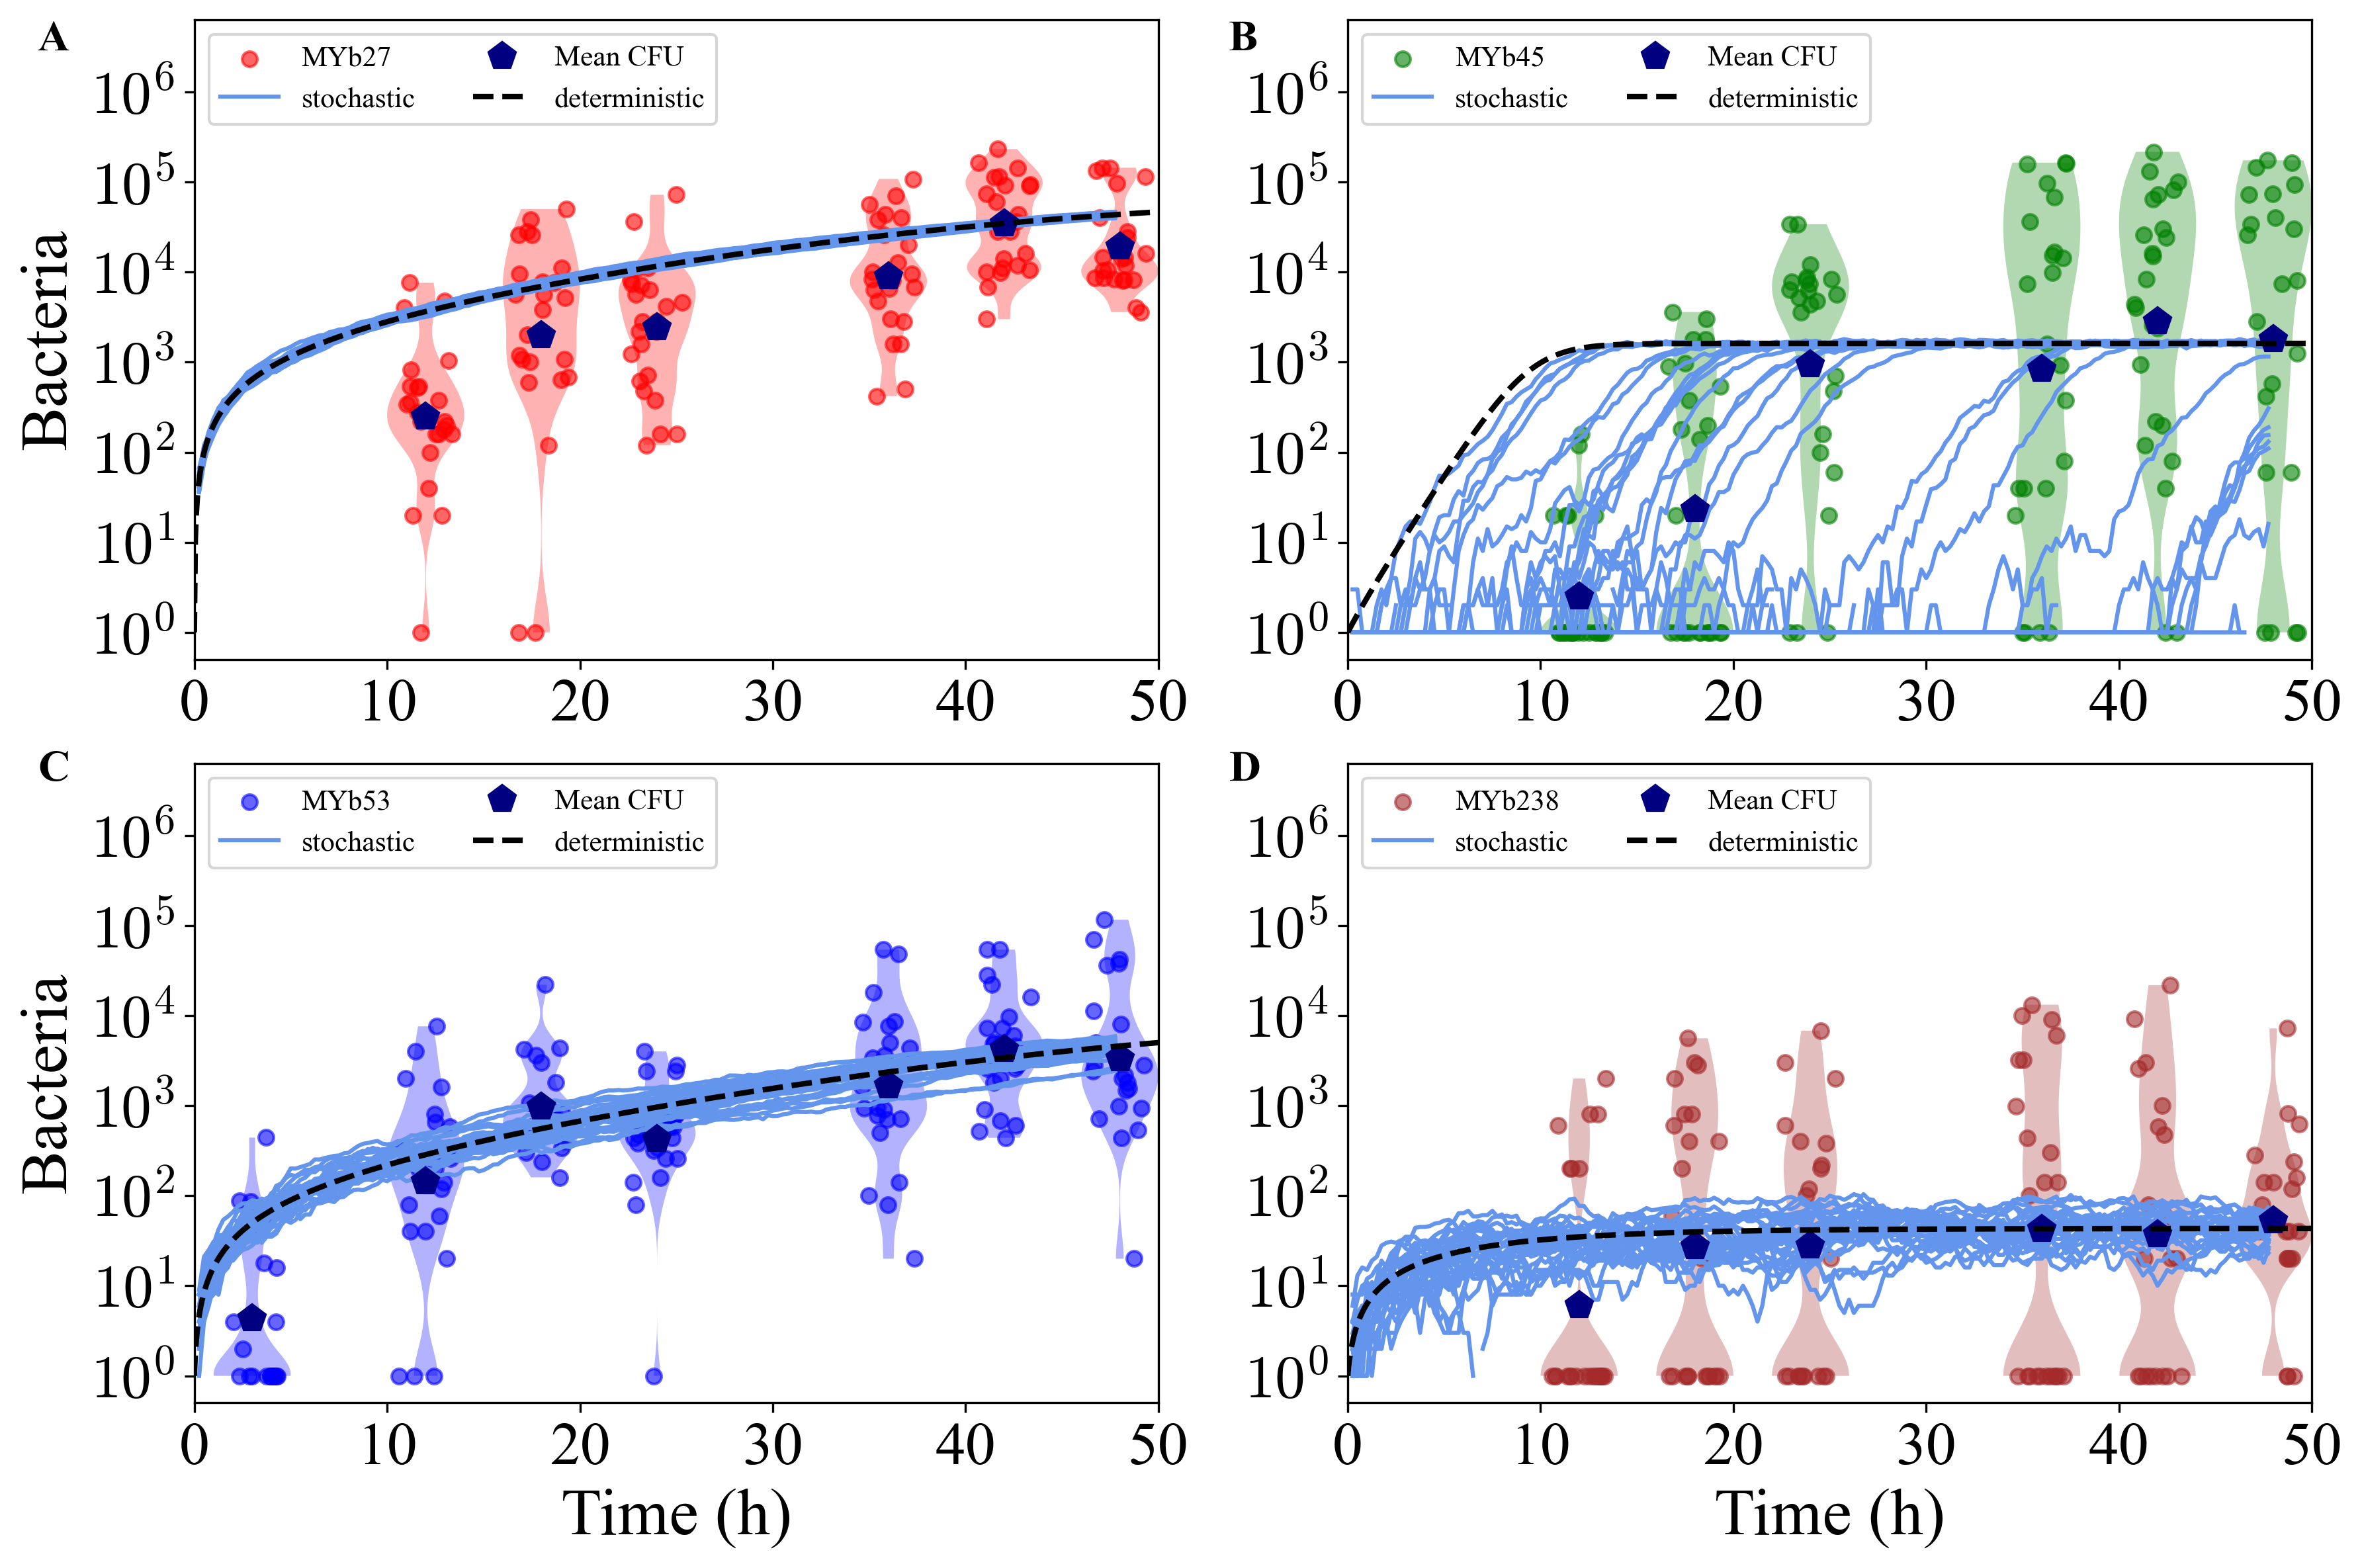

In [3]:
fig = plt.figure(figsize=(12, 8))


plt.subplot(2,2, 1)
plot_code1()

plt.subplot(2,2, 2)
plot_code2()

plt.subplot(2,2, 3)
plot_code3()

plt.subplot(2, 2,4)
plot_code4()

fig.text(0.02, 0.98, "A", fontsize=16, va='top', ha='left',weight='bold')
fig.text(0.52, 0.98, "B", fontsize=16, va='top', ha='left',weight='bold')
fig.text(0.02, 0.52, "C", fontsize=16, va='top', ha='left',weight='bold')
fig.text(0.52, 0.52, "D", fontsize=16, va='top', ha='left',weight='bold')

plt.tight_layout(w_pad= 2.0)


plt.savefig("../Figures/MonoCol_SIfig.pdf",dpi=300,  bbox_inches='tight')

plt.show()